##### This is my first notebook using tf.
##### Most of the code below and the convention were borrowed from the assignments that I worked on.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from sklearn.model_selection import train_test_split
tf.disable_eager_execution()
np.random.seed(1)
%matplotlib inline

C:\Users\thuan\Anaconda3\envs\tfe\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
from tensorflow.python.framework import ops
from tf_utils import random_mini_batches, convert_to_one_hot, predict

# Functions for building and training a model:

In [3]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    Arguments:
        n_x -- scalar, size of an image vector (num_px * num_px = 28*28 = 784)
        n_y -- scalar, number of classes (from 0 to 9, so -> 10)
    """

    X = tf.placeholder(dtype=tf.float32, shape=[n_x, None])
    Y = tf.placeholder(dtype=tf.float32, shape=[n_y, None])
    
    return X, Y

In [33]:
def initialize_parameters(transfer_parameters = None):
    """
    Initializes parameters to build a neural network with tensorflow
    Or load the model that was trained
    The shapes are:
                        W1 : [64, 784]
                        b1 : [64, 1]
                        W2 : [32, 64]
                        b2 : [32, 1]
                        W3 : [10, 32]
                        b3 : [10, 1]    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    if transfer_parameters == None:
        W1 = tf.get_variable("W1", [64, 784], initializer = tf.glorot_uniform_initializer())
        b1 = tf.get_variable("b1", [64, 1], initializer = tf.zeros_initializer(), )
        W2 = tf.get_variable("W2", [32, 64], initializer = tf.glorot_uniform_initializer())
        b2 = tf.get_variable("b2", [32, 1], initializer = tf.zeros_initializer())
        W3 = tf.get_variable("W3", [10, 32], initializer = tf.glorot_uniform_initializer())
        b3 = tf.get_variable("b3", [10, 1], initializer = tf.zeros_initializer())
    else:
        W1 = tf.Variable(transfer_parameters['W1'], name='W1')
        b1 = tf.Variable(transfer_parameters['b1'], name='b1')
        W2 = tf.Variable(transfer_parameters['W2'], name='W2')
        b2 = tf.Variable(transfer_parameters['b2'], name='b2')
        W3 = tf.Variable(transfer_parameters['W3'], name='W3')
        b3 = tf.Variable(transfer_parameters['b3'], name='b3')
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [5]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Forward propagation
    Z1 = tf.add(tf.matmul(W1, X), b1)                       # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                     # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                      # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                     # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                      # Z3 = np.dot(W3, A2) + b3
    
    return Z3

In [6]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [7]:
def nn_model(X_train, Y_train, X_dev, Y_dev, learning_rate = 0.0001,
          num_epochs = 100, minibatch_size = 128, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
        X_train -- training set, of shape (input size = 784, number of training examples = )
        Y_train -- test set, of shape (output size = 10, number of training examples = )
        X_test -- training set, of shape (input size = 784, number of training examples = )
        Y_test -- test set, of shape (output size = 10, number of test examples = )
        learning_rate -- learning rate of the optimization
        num_epochs -- number of epochs of the optimization loop
        minibatch_size -- size of a minibatch
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer, using an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the session to execute the "optimizer" and the "cost", the feedict contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                # Accumulate cost:
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
            if epoch == 50 and epoch_cost > 1.5: return None
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_dev, Y: Y_dev}))
        
        return parameters

# Load data:

In [8]:
train_data = np.genfromtxt('train.csv', delimiter=",")
print(len(train_data))

42001


In [11]:
# Remove the first row, which contains strings
train_data = train_data[1:,:]
m = len(train_data)
print(m)
print(train_data.shape)

42000
(42000, 785)


In [16]:
# Split the training data
(X_train, X_dev, Y_train, Y_dev) = train_test_split(train_data[:,1:], train_data[:,0], test_size = 0.2)

In [18]:
print(X_train.shape, Y_train.shape)
print(X_dev.shape, Y_dev.shape)

(33600, 784) (33600,)
(8400, 784) (8400,)


In [25]:
# Transpose the arrays according to convention in DL courses
X_train = X_train.T
X_dev = X_dev.T
Y_train = Y_train.T
Y_dev = Y_dev.T
print(X_train.shape, Y_train.shape)
print(X_dev.shape, Y_dev.shape)

(784, 33600) (33600,)
(784, 8400) (8400,)


In [24]:
sample_Y = Y_train[0:5].astype(int)
print(convert_to_one_hot(sample_Y, 10))

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [27]:
# Convert labels to one hot format
Y_train = convert_to_one_hot(Y_train.astype(int), 10)
Y_dev = convert_to_one_hot(Y_dev.astype(int), 10)

label = [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


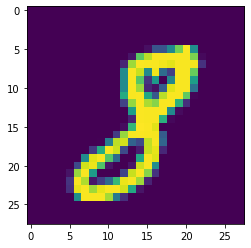

In [29]:
# Example of a picture
index = 1
plt.imshow(X_train[:,index].reshape((28,28)))
print("label = " + str(Y_train[:,index]))

In [30]:
# rescale 
X_train /= 255.0
X_dev /= 255.0

# Train nn models:

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 4.708371
Cost after epoch 10: 3.132705
Cost after epoch 20: 2.009544
Cost after epoch 30: 1.430960
Cost after epoch 40: 1.135808
Cost after epoch 50: 0.966105
Cost after epoch 60: 0.855643
Cost after epoch 70: 0.780467
Cost after epoch 80: 0.724523
Cost after epoch 90: 0.681524


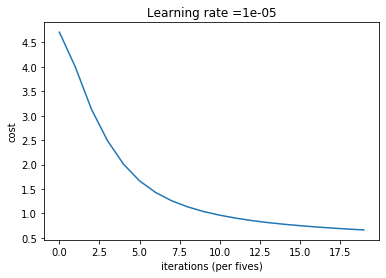

Parameters have been trained!
Train Accuracy: 0.91431546
Test Accuracy: 0.90869045


In [31]:
first_nn = nn_model(X_train, Y_train, X_dev, Y_dev, learning_rate = 0.00001, 
                    num_epochs = 100, minibatch_size = 128, print_cost = True)

Cost after epoch 0: 3.359781
Cost after epoch 10: 0.473635
Cost after epoch 20: 0.346862
Cost after epoch 30: 0.276272
Cost after epoch 40: 0.232568
Cost after epoch 50: 0.199129
Cost after epoch 60: 0.172469
Cost after epoch 70: 0.151594
Cost after epoch 80: 0.132242
Cost after epoch 90: 0.116169


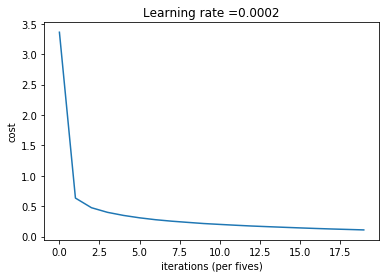

Parameters have been trained!
Train Accuracy: 0.9886905
Test Accuracy: 0.95607144


In [32]:
nn2 = nn_model(X_train, Y_train, X_dev, Y_dev, learning_rate = 0.0002, 
                    num_epochs = 100, minibatch_size = 128, print_cost = True)

# Modify functions to apply L2 penalty:

In [34]:
def compute_cost_with_regularization(Z3, Y, parameters, L2_penalty):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    # retrieve parameters for computing regularization cost
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    # compute cost with regularization cost using L2_penalty
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)) 
    cost += L2_penalty*(tf.reduce_mean(W1**2) + tf.reduce_mean(W2**2) + tf.reduce_mean(W3**2))
    
    return cost

In [39]:
def nn_model_regularized(X_train, Y_train, X_dev, Y_dev, learning_rate = 0.0001, L2_penalty = 0.0, 
                         num_epochs = 100, minibatch_size = 128, print_cost = True, print_interval = 20, 
                         transfer_parameters = None):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    This model now supports L2 regularization and parameters transfering
    
    Arguments:
        X_train -- training set, of shape (input size = 784, number of training examples = )
        Y_train -- test set, of shape (output size = 10, number of training examples = )
        X_test -- training set, of shape (input size = 784, number of training examples = )
        Y_test -- test set, of shape (output size = 10, number of test examples = )
        learning_rate -- learning rate of the optimization
        L2_penalty -- regularization rate
        num_epochs -- number of epochs of the optimization loop
        minibatch_size -- size of a minibatch
        print_interval -- the interval(num epochs) between two output of cost
        transfer_parameters -- the parameters of trained model
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(transfer_parameters)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost_with_regularization(Z3, Y, parameters, L2_penalty)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the session to execute the "optimizer" and the "cost", the feedict contains a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                # Accumulate cost:
                epoch_cost += minibatch_cost / minibatch_size

            # Append epoch cost for ploting the learning curve
            if print_cost == True: 
                costs.append(epoch_cost)
                # Print the cost every certain number of epoch
                if epoch % print_interval == 0:
                    print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_dev, Y: Y_dev}))
        
        return parameters

# Train NN with L2 regularization:

Cost after epoch 0: 2.518190
Cost after epoch 10: 0.383205
Cost after epoch 20: 0.272070
Cost after epoch 30: 0.213969
Cost after epoch 40: 0.178481
Cost after epoch 50: 0.152943
Cost after epoch 60: 0.134949
Cost after epoch 70: 0.121436
Cost after epoch 80: 0.111175
Cost after epoch 90: 0.103503


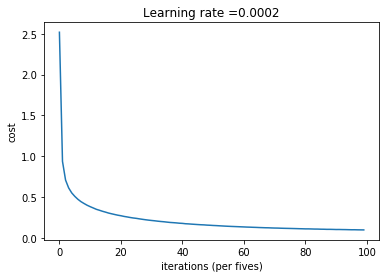

Parameters have been trained!
Train Accuracy: 0.9988988
Test Accuracy: 0.96630955


In [40]:
nn_reg0 = nn_model_regularized(X_train, Y_train, X_dev, Y_dev, learning_rate = 0.0002, L2_penalty = 0.3, 
                               num_epochs = 100, minibatch_size = 128, print_cost = True, print_interval = 10)

Cost after epoch 0: 2.628896
Cost after epoch 10: 0.500923
Cost after epoch 20: 0.390193
Cost after epoch 30: 0.331445
Cost after epoch 40: 0.294962
Cost after epoch 50: 0.268098
Cost after epoch 60: 0.248110
Cost after epoch 70: 0.233418


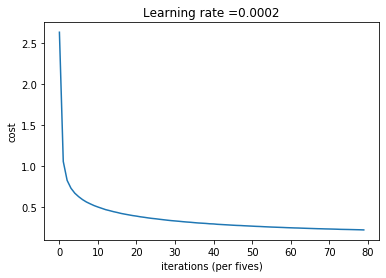

Parameters have been trained!
Train Accuracy: 0.9927976
Test Accuracy: 0.9664286


In [41]:
nn_reg1 = nn_model_regularized(X_train, Y_train, X_dev, Y_dev, learning_rate = 0.0002, L2_penalty = 1.0, 
                               num_epochs = 80, minibatch_size = 128, print_cost = True, print_interval = 10)

Cost after epoch 0: 0.219602
Cost after epoch 10: 0.213708
Cost after epoch 20: 0.209169
Cost after epoch 30: 0.204759
Cost after epoch 40: 0.201349
Cost after epoch 50: 0.197805
Cost after epoch 60: 0.194319


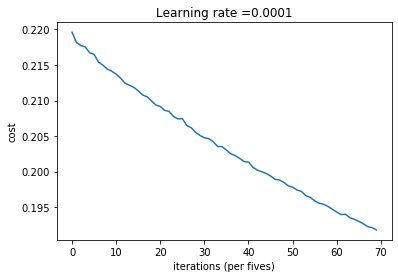

Parameters have been trained!
Train Accuracy: 0.9961905
Test Accuracy: 0.9677381


In [42]:
# keep training on nn_reg1 for another 70 epochs
nn_reg1 = nn_model_regularized(X_train, Y_train, X_dev, Y_dev, learning_rate = 0.0001, L2_penalty = 1.0, 
                               num_epochs = 70, minibatch_size = 128, print_cost = True, print_interval = 10,
                               transfer_parameters = nn_reg1)

Cost after epoch 0: 2.931303
Cost after epoch 10: 0.727485
Cost after epoch 20: 0.588032
Cost after epoch 30: 0.516415
Cost after epoch 40: 0.474118
Cost after epoch 50: 0.444147
Cost after epoch 60: 0.422659
Cost after epoch 70: 0.408266
Cost after epoch 80: 0.396547
Cost after epoch 90: 0.388161


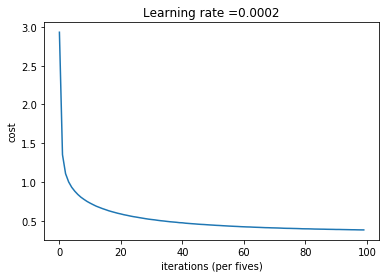

Parameters have been trained!
Train Accuracy: 0.985
Test Accuracy: 0.96630955


In [43]:
nn_reg2 = nn_model_regularized(X_train, Y_train, X_dev, Y_dev, learning_rate = 0.0002, L2_penalty = 3.0, 
                               num_epochs = 100, minibatch_size = 128, print_cost = True, print_interval = 10)

May be this is just as far as a simple NN can go.

In [44]:
print(nn_reg2)

{'W1': array([[-1.7850883e-31, -4.7993713e-31, -2.7039036e-31, ...,
         2.0746142e-31, -2.0544473e-32,  2.8799414e-31],
       [-1.5130376e-31, -1.5818803e-31, -4.9177065e-31, ...,
        -2.4027608e-31, -2.1051580e-31, -3.5308324e-31],
       [ 8.0437186e-32, -3.3198288e-31, -2.2435854e-31, ...,
        -1.0954500e-31,  2.3836569e-31, -2.2695627e-31],
       ...,
       [-2.7450708e-31,  8.9175300e-32,  1.7476554e-31, ...,
        -4.7260078e-31, -3.8302301e-31, -2.8528594e-31],
       [ 2.0087738e-31, -3.8066382e-31, -1.3580443e-31, ...,
         1.3059635e-32, -3.9650440e-31, -3.1731677e-32],
       [ 2.3258049e-31, -2.8789251e-31,  1.7220500e-31, ...,
        -4.5719060e-32,  4.8164038e-31,  7.9623197e-32]], dtype=float32), 'b1': array([[-0.08944218],
       [ 0.17011479],
       [ 0.13607296],
       [-0.11144605],
       [-0.2880621 ],
       [-0.02613726],
       [ 0.10960295],
       [ 0.04183224],
       [ 0.46743694],
       [ 0.43575475],
       [ 0.09239569],
       [

# Predictions on the test set:

In [49]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", X.shape)
    
    z3 = forward_propagation(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

### Load test set:

In [46]:
test_data = np.genfromtxt('test.csv', delimiter=",")

In [47]:
test_data = test_data[1:,:].T
print(test_data.shape)

(784, 28000)


In [50]:
predictions = predict(test_data, nn_reg2)
print(predictions.shape)

(28000,)


predicted label = 3


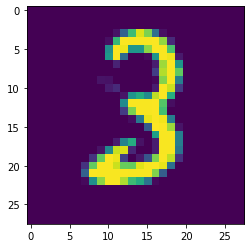

In [52]:
# Example of a prediction
index = 4
plt.imshow(test_data[:,index].reshape((28,28)))
print("predicted label = " + str(predictions[index]))

### Write predictions into a file:

In [53]:
ImageId = np.array(range(1,28001))

In [54]:
print(ImageId.shape)
print(ImageId[0:5])

(28000,)
[1 2 3 4 5]


In [58]:
predictions_data = np.array([ImageId, predictions]).astype(int).T
print(predictions_data.shape)

(28000, 2)


In [60]:
np.savetxt("simple_nn_predictions.csv", predictions_data, delimiter=",")